In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import math, bisect
import matplotlib.colors as mcolors

from pandas.plotting import parallel_coordinates
from pandas.api.types import CategoricalDtype
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# spatial analysis
import geopandas as gpd

In [2]:
sce_list_all = pd.read_csv('Ensemble_Runs_Quality_Check/sce_full_list.csv', index_col=0)

sce_all = pd.concat([sce_list_all.Ref, sce_list_all.NDC, sce_list_all.NDL]).to_frame().reset_index(drop=True)
sce_all = sce_all.rename(columns = {0:'sce_all'})

# 1) Trial 1: Sep 10

In [3]:
good_runs_outfile = pd.read_csv('Sep10_Data/good_runs_sep10_trial.csv')
fds_sep10 = pd.read_csv('Sep10_Data/fds_2050_ensemble.csv', index_col = 0)
hector_exp_sep10 = pd.read_csv('Sep10_Data/hector_exp_sep10_trial.csv')

In [4]:
fds_sep10_good_runs = fds_sep10[fds_sep10.scenario.isin(good_runs_outfile.sce)]
fds_sep10_good_runs = fds_sep10_good_runs.drop_duplicates()

In [5]:
fds_sep10_good_runs['market'] = fds_sep10_good_runs['market'].str.replace("-budget-fraction-trial-supply","")
fds_sep10_good_runs[['region','type','group']] = fds_sep10_good_runs['market'].str.split('FoodDemand', expand=True)

fds_sep10_good_runs['type'] = fds_sep10_good_runs['type'].str.replace("_","")
fds_sep10_good_runs['group'] = fds_sep10_good_runs['group'].str.replace("_","")
fds_sep10_good_runs['group'] = fds_sep10_good_runs['group'].str.replace("Group","")
fds_sep10_good_runs['group'] = [int(x) for x in fds_sep10_good_runs['group']]

In [6]:
fds_sum = fds_sep10_good_runs.groupby(['scenario','year','region','group'])['value'].sum().to_frame().reset_index()

In [7]:
fds_sum_g1 = fds_sum[fds_sum['group']==1]
fds_sum_g1['co2'] = fds_sum_g1.scenario.str.split('_', expand=True)[2]
fds_sum_g1['soc'] = fds_sum_g1.scenario.str[9]

(0.0, 1.0)

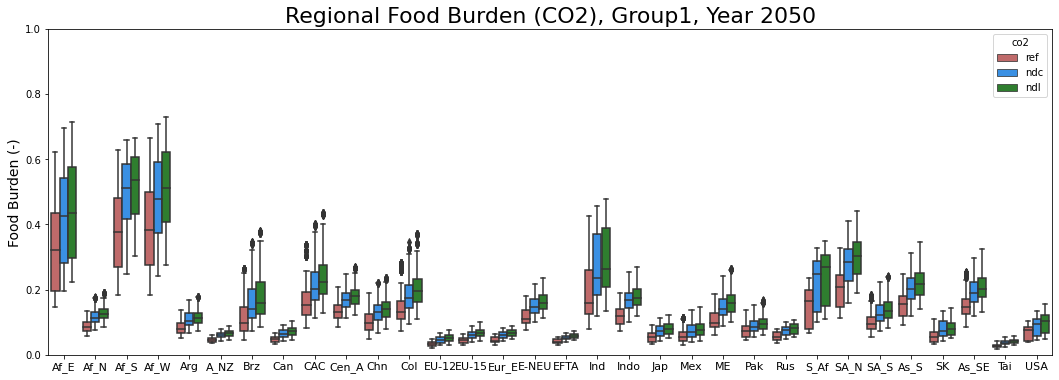

In [8]:
(fig, axis) = plt.subplots(nrows=1, ncols=1,figsize=(18,6))    

fig = sns.boxplot(x='region',y='value',hue="co2", data=fds_sum_g1, orient = 'v', 
                  hue_order=['ref', 'ndc', 'ndl'], palette=["IndianRed", "dodgerblue", "forestgreen"])

axis.set_xticklabels(["Af_E", "Af_N", "Af_S", "Af_W", "Arg","A_NZ","Brz","Can","CAC","Cen_A", "Chn",
           "Col","EU-12","EU-15","Eur_E","E-NEU","EFTA","Ind", "Indo","Jap","Mex","ME", "Pak", "Rus", "S_Af",
           "SA_N", "SA_S", "As_S","SK","As_SE","Tai","USA"], size=11)

axis.set_xlabel('', size=14)
axis.set_ylabel('Food Burden (-)', size=14)
axis.set_title('Regional Food Burden (CO2), Group1, Year 2050', size=22)

axis.set_ylim(0,1)

In [9]:
sep10_good_runs_sce = fds_sep10_good_runs.drop(['Units','year',"market","value",'region','type','group'],axis=1)
sep10_good_runs_sce = sep10_good_runs_sce.drop_duplicates().reset_index(drop=True)

sce_check_Sep10 = pd.merge(sce_all, sep10_good_runs_sce, how = 'left', left_on = ['sce_all'], right_on = ['scenario'])

In [10]:
sce_failed_sep10 = sce_check_Sep10[sce_check_Sep10.scenario.isna()]
sce_failed_sep10

,sce_all,scenario
504,kim_mcfe_ref_soc3_ag1_fd1_bldBEESatLevel_canes...,NaN
505,kim_mcfe_ref_soc3_ag1_fd1_bldBEESatLevel_canes...,NaN
507,kim_mcfe_ref_soc3_ag1_fd1_bldBEESatLevel_canes...,NaN
508,kim_mcfe_ref_soc3_ag1_fd1_bldBEESatLevel_canes...,NaN
510,kim_mcfe_ref_soc3_ag1_fd1_bldBEESatLevel_gfdl_...,NaN
...,...,...
3450,kim_mcfe_ndl_soc3_ag3_fd1_bldSatLevel_ipsl_res...,NaN
3451,kim_mcfe_ndl_soc3_ag3_fd1_bldSatLevel_ipsl_res...,NaN
3453,kim_mcfe_ndl_soc3_ag3_fd1_bldSatLevel_ipsl_res...,NaN
3454,kim_mcfe_ndl_soc3_ag3_fd1_bldSatLevel_ipsl_res...,NaN


In [11]:
sce_group_list = ['ref_soc2','ref_soc3','ref_soc5','ndc_soc2','ndc_soc3','ndc_soc5','ndl_soc2','ndl_soc3','ndl_soc5']

for i in range(0,len(sce_group_list)):
    print(sce_group_list[i] + ', ' + str(sum(sce_failed_sep10.sce_all.str.contains(sce_group_list[i]))))

ref_soc2, 0
ref_soc3, 144
ref_soc5, 0
ndc_soc2, 32
ndc_soc3, 164
ndc_soc5, 56
ndl_soc2, 9
ndl_soc3, 174
ndl_soc5, 1


In [12]:
outpath = '/cluster/tufts/lamontagnelab/gkim14/GCAM/mult_cons_food_plus_energy/gcam-core/exe/outfiles_trial1_12500/'

In [13]:
outfilelist_all = os.listdir(outpath)
large_file_omit = ['7558944.59.out', '7558944.130.out', '7422174.27.out', '7558944.60.out', '7422174.380.out', 
                   '7422174.262.out', '7558944.242.out', '7558944.376.out', '7422174.418.out', '7418145.248.out']

outfilelist = [e for e in outfilelist_all if e not in large_file_omit]

In [14]:
df_outfile_org = pd.DataFrame(index = range(len(outfilelist)), columns = range(3))
df_outfile_org.columns = ['outfile','scenario','results']

In [15]:
for i in range(0,len(outfilelist)):
    file = open(outpath + outfilelist[i], mode = 'r', encoding = 'utf-8-sig')
    lines = file.readlines()
    
    df_outfile_org.outfile[i] = outfilelist[i]
    
    if not 'XML parsing complete.\n' in lines:
        pass
    else:
        index_sce = lines.index('XML parsing complete.\n')
        df_outfile_org.scenario[i] = lines[index_sce+1:index_sce+2]
    
    if not 'Period 11: 2050\n' in lines:
        pass
    elif not 'Period 12: 2055\n' in lines:
        pass
    else: 
        index_2050 = lines.index('Period 11: 2050\n')
        index_2055 = lines.index('Period 12: 2055\n')

    df_outfile_org.results[i] = lines[index_2050 + 1:index_2055 -1]

In [16]:
df_outfile_org['results'] = df_outfile_org['results'].astype(str)

In [17]:
df_outfile_org_correct = df_outfile_org[df_outfile_org.results.str.contains('Model solved normally. Iterations period 11:')]
df_outfile_org_incorrect = df_outfile_org[~df_outfile_org.results.str.contains('Model solved normally. Iterations period 11:')]

In [18]:
df_outfile_org_incorrect_nd = df_outfile_org_incorrect[df_outfile_org_incorrect.results.str.contains('Normal','Demand')]
index_nd = df_outfile_org_incorrect_nd.index

df_outfile_org_incorrect_trial = df_outfile_org_incorrect[~df_outfile_org_incorrect.index.isin(index_nd)]

In [19]:
df_outfile_org_incorrect_missing = df_outfile_org_incorrect[~df_outfile_org_incorrect.scenario.str.contains("Starting new scenario: ")]
df_outfile_org_incorrect_missing

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [22]:
df_outfile_org_incorrect_trial = df_outfile_org_incorrect_trial.reset_index(drop = True)

In [24]:
df_outfile_org_incorrect_trial.to_csv('Sep10_Data/incorrect_trial_sep10_trial.csv')

In [ ]:
df_outfile_org_incorrect_trial

# 2) Trial 2: